In [15]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

from matplotlib.ticker import MaxNLocator
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [16]:
k = 20 # Top 10% highest l2-magnitude filters

In [17]:
k=5

F = 0

filters = np.zeros((k,k,1,1))

t = np.zeros((k,k))
t[1, 0] = np.sqrt(0.5)
t[0, 0] = np.sqrt(0.5)
filters = np.reshape(fft.idctn(t, norm='ortho'), (k,k,1,1)) 
filters /= np.sum((filters)**2)

filters[:,0,0,0] = 0.
filters[:,-1,0,0] = 0.

#filters[:,:,0,0] =  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) + (1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) 


'''theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


print(a_mag**2 / mag**2)

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'}) '''




"theta = getSobelTF(filters)\nprint(filters.shape)\ns, a = getSymAntiSymTF(filters)\n\na_mag = reduce_euclidean_norm(a, axis=[0,1])\ns_mag = reduce_euclidean_norm(s, axis=[0,1])\nmag = reduce_euclidean_norm(filters, axis=[0,1])\n\n\nprint(a_mag**2 / mag**2)\n\nx =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()\ny =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()\nz =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()\nplt.rcParams.update({'figure.dpi': '100'}) "

In [18]:
filters[:,:,0,0]

array([[ 0.        ,  0.33163266,  0.33163266,  0.33163266,  0.        ],
       [ 0.        ,  0.25897841,  0.25897841,  0.25897841,  0.        ],
       [ 0.        ,  0.14142136,  0.14142136,  0.14142136,  0.        ],
       [ 0.        ,  0.02386431,  0.02386431,  0.02386431,  0.        ],
       [ 0.        , -0.04878995, -0.04878995, -0.04878995,  0.        ]])

In [19]:
3//2

1

In [20]:
#var = 2/(128*9)

img = np.zeros((115,115)) # cv2.imread('input4.png', 0)/255. 
mid = img.shape[0]//2
img[mid, mid] = 1.
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(115, 115)


(324, 324)
(324, 324)


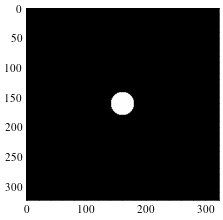

In [21]:
img =  cv2.imread('input4.png', 0)/255. 
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)


img = cv2.copyMakeBorder(img, 
                                top=50, bottom=50, 
                                left=50, right=50, 
                                borderType=cv2.BORDER_CONSTANT, 
                                value=0)


print(img.shape)

mid = img.shape[0]//2



#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

plt.imshow(img, cmap='gray')

In [22]:
np.var(img), 1/(128*9)


(np.float64(0.011151557861979779), 0.0008680555555555555)

In [23]:
np.linspace(-round(0.1)-1, round(0.1)+1, int(0.5*(0.1)+3))

array([-1.,  0.,  1.])

(5, 5, 1, 1)
0
(1, 324, 324, 1)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 10.999806
(1, 324, 324, 1)
100 [-75 -50 -25] [  0  25  50  75 100 125]
1
(1, 324, 324, 1)
VALS 1.0000001
tf.Tensor(1.3536627, shape=(), dtype=float32) 11.043499
(1, 324, 324, 1)
100 [-75 -50 -25] [  0  25  50  75 100 125]
2
3
4
5
6
7
8
9
10
(1, 324, 324, 1)
VALS 0.99999994
tf.Tensor(13.875771, shape=(), dtype=float32) 11.194164
(1, 324, 324, 1)
100 [-75 -50 -25] [  0  25  50  75 100 125]
11
12
13
14
15
16
17
18
19
20
(1, 324, 324, 1)
VALS 1.0
tf.Tensor(27.889675, shape=(), dtype=float32) 11.248956
(1, 324, 324, 1)
100 [-75 -50 -25] [  0  25  50  75 100 125]
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
(1, 324, 324, 1)
VALS 1.0
tf.Tensor(55.99672, shape=(), dtype=float32) 11.26648
(1, 324, 324, 1)
100 [-75 -50 -25] [  0  25  50  75 100 125]
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
(1, 324, 324, 1)
VALS 1.0
tf.Tensor(84.15001, shape=(), dtype=float32) 11.253523
(1, 324, 324,

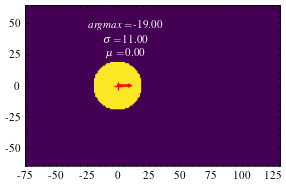

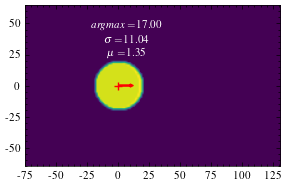

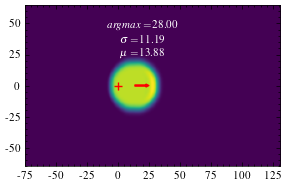

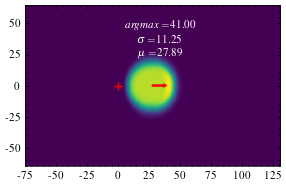

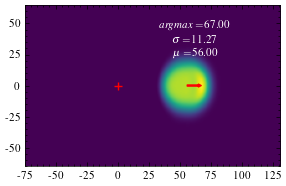

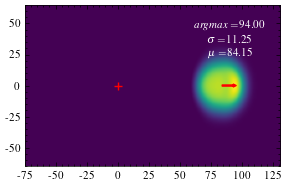

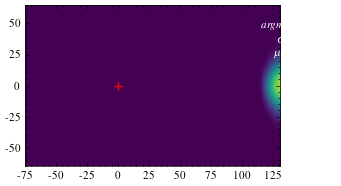

In [24]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img


directory = f"figures/prop_unipolar_0.25"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(101):
	print(i)
	if i in [0, 1,10, 20, 40, 60, 100]:
		fig, ax = plt.subplots()
		print(x.shape)
		x = x/np.std(x)
		vals = x[0, x.shape[1]//2, :, :]
		vals = vals/np.sum(vals)

		print("VALS", np.sum(vals))
		pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
		mean = tf.reduce_sum(pos*vals)
		var = tf.reduce_sum(((pos-mean)**2) * vals)
		std = np.sqrt(var)
		print(mean, np.sqrt(var))
		
		#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
		print(x.shape)

		im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
		ax.plot(mid, mid, marker = '+', color='red')

		#ax.plot(112+mean, 112, marker = ".", color='black')
		arr =  mpatches.FancyArrowPatch((mid+mean, mid), (mid+mean+std, mid),
								mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
		ax.add_patch(arr)
		
		ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 15), xycoords=arr, ha='center', va='bottom',color='white')
		ax.annotate(r'$\mu=$'+f"{mean:.2f}", (.5, 10), xycoords=arr, ha='center', va='bottom',color='white')
		ax.annotate(r'$argmax=$'+f"{np.argmax(vals)-mid:.2f}", (.5, 20), xycoords=arr, ha='center', va='bottom',color='white')

		#ax.arrow(, 112, dx=, dy= 0, color='black')

		xlim = (mid - 53, mid + 131)
		ylim = (mid - 65, mid + 65)
		ax.set_xlim(xlim)
		ax.set_ylim(ylim)

		# Define spacing
		step = 25

		# Compute ticks centered around `mid`, spaced by `step`, covering full view
		xticks_neg =   np.arange(-53//step * step, 0, step)
		xticks_pos = np.arange(0, 130 , step)
		xticks = np.concatenate((xticks_neg, xticks_pos)) + mid

		yticks_neg = np.arange(-65//step * step, 0, step)
		yticks_pos = np.arange(0, 65//step * step , step)
		yticks =  np.array([-50, -25, 0, 25, 50]) + mid  #np.concatenate((yticks_neg, yticks_pos)) + mid


		print(xlim[0] // step * step, xticks_neg, xticks_pos)


		# Ensure mid (origin) is present

		# Apply ticks and relabel with 0-centered view
		#xticks = np.arange(xlim[0]+1, xlim[1]+1 , step)
		#yticks = np.arange(ylim[0]+1, ylim[1]+1, step)

		# Set tick positions and labels (centered around mid)
		ax.set_xticks(xticks)
		ax.set_yticks(yticks)
		ax.set_xticklabels([x - mid for x in xticks])
		ax.set_yticklabels([y - mid for y in yticks])


		#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
		#fig.colorbar(im, orientation='vertical')
		fig.savefig(directory + f'/{i}.pdf', dpi=150,  transparent=True, bbox_inches='tight')

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )

In [25]:
65//step * step

50

(0.0, 224.0)

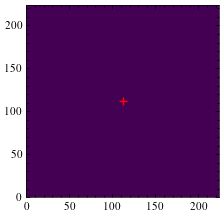

In [26]:
x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
						padding='SAME') )
	
im = plt.imshow(np.sum(x[0,:,:,:], axis=-1))
plt.plot(112, 112, marker = '+', color='red')
plt.xlim([0, 224])#, ylim=(0, 224))
plt.ylim([0, 224])#, ylim=(0, 224))

#, ylim=(0, 224))

In [27]:
mean

<tf.Tensor: shape=(), dtype=float32, numpy=140.21131896972656>

In [28]:
pos[x.shape[1]//2]

array([0.50154799])